# Submission 1, ML Assignment 1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.externals import joblib
from my_measures import BinaryClassificationPerformance
%matplotlib inline

### Read raw test data

In [2]:
amazon = pd.read_csv('raw_data_test.csv')
print(amazon.shape) 

(91000, 14)


In [3]:
print(amazon.head())
print(amazon['helpful'].mean()) 

   Unnamed: 0  Unnamed: 0.1      Id   ProductId          UserId  \
0      264540        182243  182244  B005OSC218   AJZXTZ3I9A84H   
1      146085        548350  548351  B004VLVD50  A39RNG8DUXG7ZM   
2      281714        539422  539423  B001BDDT8K  A2FRFAQCWZJT3Q   
3      280559        119141  119142  B001U0ON5M  A1YREIUL7VDQ0B   
4      236948        352256  352257  B000E63L8S  A3JKXNOLX2QRJ7   

                         ProfileName  HelpfulnessNumerator  \
0                             Jeromy                     1   
1                         W. Chapman                     4   
2        B. Davis "The Happy Hermit"                     1   
3   Jennifer U. Heston "ex-academic"                     0   
4  darlene conright "alaskan darlin"                     2   

   HelpfulnessDenominator  Score        Time                  Summary  \
0                       1      5  1316995200                 The Best   
1                       4      5  1331596800  Makes great dog bones !   
2    

### Feature extraction on natural language data

In [4]:
# # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# from sklearn.feature_extraction.text import CountVectorizer
# vectorizer = CountVectorizer()
# corpus = amazon.Text.as_matrix()
# X_bag_of_words = vectorizer.fit_transform(corpus)
# print(X_bag_of_words.toarray())

In [5]:
import nltk
# nltk.download('punkt')
# nltk.download('popular')

from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

In [6]:
# vectorize Bag of Words from review text; as sparse matrix
# from sklearn.feature_extraction.text import HashingVectorizer
# hv = HashingVectorizer(n_features=2 ** 17, non_negative=True)

hv0 = joblib.load('../amazon/hv0.pkl')
#X_hv = hv.transform(amazon.Text)
amazon['timeFilter'] = amazon['Time'].apply(lambda x: str(int(x)%(86400 * 7))) # converts to day of week
X_hv0 = hv0.transform(amazon.timeFilter + " " + amazon.ProductId + " " + amazon.UserId + " " + amazon.Text) # mw adds uid as token

# and a second domain where we look at the summary
amazon['summaryFilter'] = amazon['Summary'].apply(lambda x: " " if x is np.nan else x) # some were np.nans
hv1 = joblib.load('../amazon/hv1.pkl')
X_hv1 = hv1.transform(amazon.summaryFilter) 


import scipy.sparse as sp
X_hv = sp.hstack([X_hv0, X_hv1], format='csr')

print(X_hv.shape)

/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


/home/wolfm2/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


(91000, 786432)


In [7]:
# http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
# from sklearn.feature_extraction.text import TfidfTransformer
# transformer = TfidfTransformer()
transformer = joblib.load('../amazon/transformer.pkl') 
X_tfidf = transformer.transform(X_hv)

In [8]:
print(type(X_tfidf))

<class 'scipy.sparse.csr.csr_matrix'>


### Create additional quantitative features

In [9]:
# features from Amazon.csv to add to feature set
amazon['reviewLen'] = amazon['Text'].str.len()

amazon['summaryLen'] = amazon['summaryFilter'].str.len()
#import zlib
#amazon['nameHash'] = zlib.crc32(str(amazon['UserId']).encode('utf8'))
#amazon['nameHash'] = amazon['UserId'].apply(lambda x: zlib.crc32(str(x).encode('utf8'))) # bad. don't do it this way

X_quant_features = amazon[["Score", "reviewLen", "summaryLen"]]

# X_quant_features = amazon[["Score", "reviewLen"]]
print(X_quant_features.head(10))
print(type(X_quant_features))

   Score  reviewLen  summaryLen
0      5        167           8
1      5        259          23
2      5        429          13
3      1        607          10
4      5        202           9
5      5        816          46
6      5        459          64
7      4        401          14
8      5        100          17
9      5        582          12
<class 'pandas.core.frame.DataFrame'>


### Combine all quantitative features into a single sparse matrix

In [10]:
from scipy.sparse import csr_matrix, hstack
X_quant_features_csr = csr_matrix(X_quant_features)
X_combined = hstack([X_tfidf, X_quant_features_csr])
X_matrix = csr_matrix(X_combined) # convert to sparse matrix
print(X_matrix.shape)

(91000, 786435)


### Create `X`, scaled matrix of features

In [11]:
# feature scaling
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler(with_mean=False)
sc = joblib.load('../amazon/sc.pkl')
X = sc.transform(X_matrix)
print(X.shape)

(91000, 786435)


### create `y`, vector of Labels

In [12]:
y = amazon['helpful'].values
print(type(y))

<class 'numpy.ndarray'>


### predict `y` with the fit on the training set

In [13]:
# MODEL: best from search
from sklearn import linear_model

lgs = joblib.load('../amazon/best.pkl') # pickle

lgs_performance = BinaryClassificationPerformance(lgs.predict(X), y, 'best')
lgs_performance.compute_measures()
print(lgs_performance.performance_measures)

{'Pos': 6588, 'Neg': 84412, 'TP': 2396, 'TN': 81550, 'FP': 2862, 'FN': 4192, 'Accuracy': 0.92248351648351645, 'Precision': 0.45568657284138453, 'Recall': 0.36369156041287187, 'desc': 'best'}


### ROC plot to compare performance of various models and fits

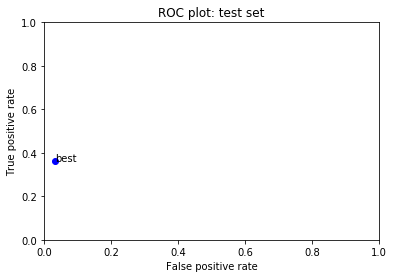

In [14]:
fits = [lgs_performance]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()